Usecase test 3: Can links be found relating to predispositions for ASD co-morbidities?

1. Take count of genes cited in the data across all articles highlighting the most cited overall (by most connections)

In [1]:
import rdflib

filename = "cleaned_maingraph.nt"
g = rdflib.Graph()
g.parse(filename, format="nt")
count_query = """
    PREFIX EDAM: <http://edamontology.org/>
    PREFIX RDF: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX DCT: <http://purl.org/dc/terms/>
    PREFIX BIOLINK: <https://w3id.org/biolink/vocab/>
    PREFIX ENSEMBL: <http://identifiers.org/ensembl/>
    PREFIX NCBIGENE: <http://identifiers.org/ncbigene/>

    SELECT ?gene (COUNT(?subject) AS ?count)
    WHERE {
        ?subject BIOLINK:Gene ?gene .
    }
    GROUP BY ?gene
    ORDER BY DESC(?count)
    LIMIT 10
"""

results = g.query(count_query)
print("Gene | Count")
print("-----|------")
for row in results:
    gene = str(row['gene'])
    count = int(row['count'].toPython()) 
    print(f"{gene} | {count}")

Gene | Count
-----|------
https://monarchinitiative.org/HGNC:18222 | 982
https://monarchinitiative.org/HGNC:2905 | 329
https://monarchinitiative.org/HGNC:37462 | 280
https://monarchinitiative.org/HGNC:11969 | 225
https://monarchinitiative.org/HGNC:2550 | 177
https://monarchinitiative.org/HGNC:597 | 167
https://monarchinitiative.org/HGNC:9466 | 167
https://monarchinitiative.org/HGNC:16286 | 160
https://monarchinitiative.org/HGNC:2678 | 149
https://monarchinitiative.org/HGNC:7643 | 148


In [5]:
count_query = """
    PREFIX EDAM: <http://edamontology.org/>
    PREFIX RDF: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX DCT: <http://purl.org/dc/terms/>
    PREFIX BIOLINK: <https://w3id.org/biolink/vocab/>
    PREFIX ENSEMBL: <http://identifiers.org/ensembl/>
    PREFIX NCBIGENE: <http://identifiers.org/ncbigene/>

    SELECT ?gene (COUNT(DISTINCT ?root_subject) AS ?count)
    WHERE {
        ?root_subject ?p ?o
        FILTER(STRSTARTS(STR(?root_subject), "https://pubmed.ncbi.nlm.nih.gov/"))
        ?root_subject ?p1 ?intermediate1 .
        ?intermediate1 ?p2 ?intermediate2 .
        ?intermediate2 BIOLINK:Gene ?gene .
    }
    GROUP BY ?gene
    ORDER BY DESC(?count)
    LIMIT 10
"""
results = g.query(count_query)
print("Gene | Count")
print("-----|------")
for row in results:
    gene = str(row['gene'])
    count = int(row['count'].toPython()) 
    print(f"{gene} | {count}")

Gene | Count
-----|------
https://monarchinitiative.org/HGNC:5246 | 9
https://monarchinitiative.org/HGNC:3999 | 9
https://monarchinitiative.org/HGNC:10471 | 9
https://monarchinitiative.org/HGNC:1180 | 9
https://monarchinitiative.org/HGNC:2095 | 8
https://monarchinitiative.org/HGNC:3797 | 8
https://monarchinitiative.org/HGNC:2475 | 8
https://monarchinitiative.org/HGNC:1943 | 8
https://monarchinitiative.org/HGNC:2905 | 8
https://monarchinitiative.org/HGNC:20256 | 8


In [ ]:

import rdflib

filename = "cleaned_maingraph.nt"
g = rdflib.Graph()
g.parse(filename, format="nt")
count_query = """
    PREFIX EDAM: <http://edamontology.org/>
    PREFIX RDF: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX DCT: <http://purl.org/dc/terms/>
    PREFIX BIOLINK: <https://w3id.org/biolink/vocab/>
    PREFIX ENSEMBL: <http://identifiers.org/ensembl/>
    PREFIX NCBIGENE: <http://identifiers.org/ncbigene/>

    SELECT ?gene (COUNT(DISTINCT ?subject) AS ?count)
    WHERE {
        {
            SELECT ?subject (SAMPLE(?gene_value) AS ?gene)
            WHERE {
                {
                    ?subject BIOLINK:Gene ?gene_value .
                }
                UNION
                {
                    ?subject BIOLINK:symbol ?gene_value .
                    FILTER NOT EXISTS { ?subject BIOLINK:Gene ?any_gene }
                }
                UNION
                {
                    ?subject ENSEMBL:id ?gene_value .
                    FILTER NOT EXISTS { 
                        ?subject BIOLINK:Gene ?any_gene 
                        UNION 
                        ?subject BIOLINK:symbol ?any_symbol
                    }
                }
                UNION
                {
                    ?subject NCBIGENE:id ?gene_value .
                    FILTER NOT EXISTS { 
                        ?subject BIOLINK:Gene ?any_gene 
                        UNION 
                        ?subject BIOLINK:symbol ?any_symbol
                        UNION
                        ?subject ENSEMBL:id ?any_ensembl
                    }
                }
            }
            GROUP BY ?subject
        }
    }
    GROUP BY ?gene
    ORDER BY DESC(?count)
"""

results = g.query(count_query)
print("Gene | Count")
print("-----|------")
for row in results:
    gene = str(row['gene'])
    count = int(row['count'].toPython()) 
    print(f"{gene} | {count}")
              

2. Query external Monarch Initiative graph using API using these top-cited genes for related phenotypes 

In [6]:
top_genes = []
for row in results:
    top_genes.append(str(row['gene']))
print(top_genes)

['https://monarchinitiative.org/HGNC:5246', 'https://monarchinitiative.org/HGNC:3999', 'https://monarchinitiative.org/HGNC:10471', 'https://monarchinitiative.org/HGNC:1180', 'https://monarchinitiative.org/HGNC:2095', 'https://monarchinitiative.org/HGNC:3797', 'https://monarchinitiative.org/HGNC:2475', 'https://monarchinitiative.org/HGNC:1943', 'https://monarchinitiative.org/HGNC:2905', 'https://monarchinitiative.org/HGNC:20256']


In [9]:
from rdflib import Graph
from SPARQLWrapper import SPARQLWrapper, JSON

# Strip the prefixes to get just the HGNC IDs
hgnc_ids = [gene.split('/')[-1] for gene in top_genes]  # Extracts 'HGNC:6190', etc.

# Define the SPARQL endpoint
sparql = SPARQLWrapper("https://bio2rdf.org/sparql")

# Convert the list to a SPARQL-compatible VALUES clause with full IRIs
hgnc_values = " ".join(f"<http://bio2rdf.org/{hgnc_id}>" for hgnc_id in hgnc_ids)

# Define your SPARQL query with the VALUES clause
query = f"""
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX bio2rdf: <http://bio2rdf.org/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?gene ?function ?function_label WHERE {{
    VALUES ?gene {{ {hgnc_values} }}
    ?gene a bio2rdf:gene .
    ?gene obo:RO_0002162 ?function .
    ?function rdfs:label ?function_label .
}}
LIMIT 10
"""

# Set the query and return format
sparql.setQuery(query)
sparql.setReturnFormat(JSON)

# Execute the query and print results
try:
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        gene = result["gene"]["value"]
        function = result["function"]["value"]
        function_label = result["function_label"]["value"]
        print(f"Gene: {gene}, Function: {function}, Label: {function_label}")
except Exception as e:
    print(f"An error occurred: {e}")

In [2]:
import requests
import pandas as pd
from collections import defaultdict

top_genes = [str(row['gene']) for row in results]   # using the most common genes from the KG above

#converting gene names to Monarch's gene number
def get_gene_id(gene_name):
    search_url = "https://api-v3.monarchinitiative.org/v3/api/search"
    params = {
        "q": gene_name,
        "category": "biolink:Gene",
        "limit": 1
    }
    try:
        response = requests.get(search_url, params=params)
        response.raise_for_status()
        data = response.json()
        if data['items']:
            return data['items'][0]['id']
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while searching for {gene_name}: {e}")
    return None

#getting all associations from monarch api
def get_associations(gene_id, association_type):
    api_url = "https://api-v3.monarchinitiative.org/v3/api/association"
    params = {
        "subject": gene_id,
        "predicate": association_type,
        "offset": 0,
        "limit": 100
    }
    try:
        response = requests.get(api_url, params=params)
        response.raise_for_status()
        data = response.json()
        return data.get('items', [])
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return []

def get_gene_info(gene_name):
    gene_id = get_gene_id(gene_name)
    if not gene_id:
        print(f"Could not find ID for gene {gene_name}")
        return {}
    
    #using predicates to return relevant associations
    phenotypes = get_associations(gene_id, "biolink:has_phenotype")
    diseases = get_associations(gene_id, "biolink:gene_associated_with_condition")
    processes = get_associations(gene_id, "biolink:participates_in")
    functions = get_associations(gene_id, "biolink:enables")
    
    return {
        'Phenotypes': [item.get('object_label', 'Unknown') for item in phenotypes],
        'Diseases': [item.get('object_label', 'Unknown') for item in diseases],
        'Biological Processes': [item.get('object_label', 'Unknown') for item in processes],
        'Molecular Functions': [item.get('object_label', 'Unknown') for item in functions]
    }

results = {}
for gene in top_genes:
    results[gene] = get_gene_info(gene)




Molecular Functions:
Molecular Functions                                         Genes
    protein binding CIRBP, ERBB4, KAZN, KCND2, NRXN1, PTMA, RAB3C
  metal ion binding                          KCND2, MGAT4C, NRXN1

Unique associations for each gene:

CIRBP:
  Molecular Functions:
    - RNA binding
    - mRNA 3'-UTR binding
    - small ribosomal subunit rRNA binding
    - translation repressor activity

NRXN1:
  Phenotypes:
    - Autosomal recessive inheritance
    - Broad-based gait
    - Constipation
    - Developmental regression
    - Drooling
    - Epileptic encephalopathy
    - Feeding difficulties
    - Gastroesophageal reflux
    - Generalized hypotonia
    - Hyperventilation
    - Hypotonia
    - Intellectual disability, severe
    - Protruding tongue
    - Pulmonic stenosis
    - Scoliosis
    - Strabismus
    - Wide mouth
  Diseases:
    - NRXN1-related severe neurodevelopmental disorder-motor stereotypies-chronic constipation-sleep-wake cycle disturbance
  Biological P

In [13]:
import requests
import pandas as pd
from collections import defaultdict

hgnc_ids = [gene.split('/')[-1] for gene in top_genes]
#getting all associations from monarch api
def get_associations(gene_id, association_type):
    api_url = "https://api-v3.monarchinitiative.org/v3/api/association"
    params = {
        "subject": gene_id,
        "predicate": association_type,
        "offset": 0,
        "limit": 100
    }
    try:
        response = requests.get(api_url, params=params)
        response.raise_for_status()
        data = response.json()
        return data.get('items', [])
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return []

def get_gene_info(gene_id):
    
    #using predicates to return relevant associations
    phenotypes = get_associations(gene_id, "biolink:has_phenotype")
    diseases = get_associations(gene_id, "biolink:gene_associated_with_condition")
    processes = get_associations(gene_id, "biolink:participates_in")
    functions = get_associations(gene_id, "biolink:enables")
    
    return {
        'Phenotypes': [item.get('object_label', 'Unknown') for item in phenotypes],
        'Diseases': [item.get('object_label', 'Unknown') for item in diseases],
        'Biological Processes': [item.get('object_label', 'Unknown') for item in processes],
        'Molecular Functions': [item.get('object_label', 'Unknown') for item in functions]
    }

results = {}
for gene in hgnc_ids:
    results[gene] = get_gene_info(gene)


In [14]:

# Create a summary of shared associations between the given genes (using set to remove duplicates)
shared_associations = defaultdict(lambda: defaultdict(set))
for category in ['Phenotypes', 'Diseases', 'Biological Processes', 'Molecular Functions']:
    all_items = set()
    for gene, data in results.items():
        all_items.update(data.get(category, []))
    
    for item in all_items:
        genes_with_item = set(gene for gene, data in results.items() if item in data.get(category, []))
        if len(genes_with_item) > 1:
            shared_associations[category][item] = genes_with_item

for category, items in shared_associations.items():
    print(f"\n{category}:")
    if items:
        df = pd.DataFrame([(item, ', '.join(sorted(genes))) for item, genes in items.items()], 
                          columns=[category, 'Genes'])
        print(df.to_string(index=False))
    else:
        print("No shared associations found.")

# Print unique associations for each gene
print("\nUnique associations for each gene:")
for gene, data in results.items():
    print(f"\n{gene}:")
    for category, items in data.items():
        unique_items = set(item for item in items if len(shared_associations[category].get(item, [])) <= 1)
        if unique_items:
            print(f"  {category}:")
            for item in sorted(unique_items):
                print(f"    - {item}")
                


Phenotypes:
                    Phenotypes                                                  Genes
Autosomal dominant inheritance HGNC:10471, HGNC:1943, HGNC:2475, HGNC:3999, HGNC:5246
                    Arthralgia                                  HGNC:10471, HGNC:3999
                   Adult onset                                   HGNC:3999, HGNC:5246
                       Fatigue                                  HGNC:10471, HGNC:3999
              Middle age onset                                   HGNC:3999, HGNC:5246
            Difficulty walking                                   HGNC:3999, HGNC:5246
           Talipes equinovarus                                   HGNC:1943, HGNC:5246
                      Dementia                                   HGNC:2475, HGNC:3999
                 Blepharospasm                                   HGNC:1943, HGNC:3999

Biological Processes:
              Biological Processes                 Genes
Estrogen-dependent gene expression HGNC:10471, 

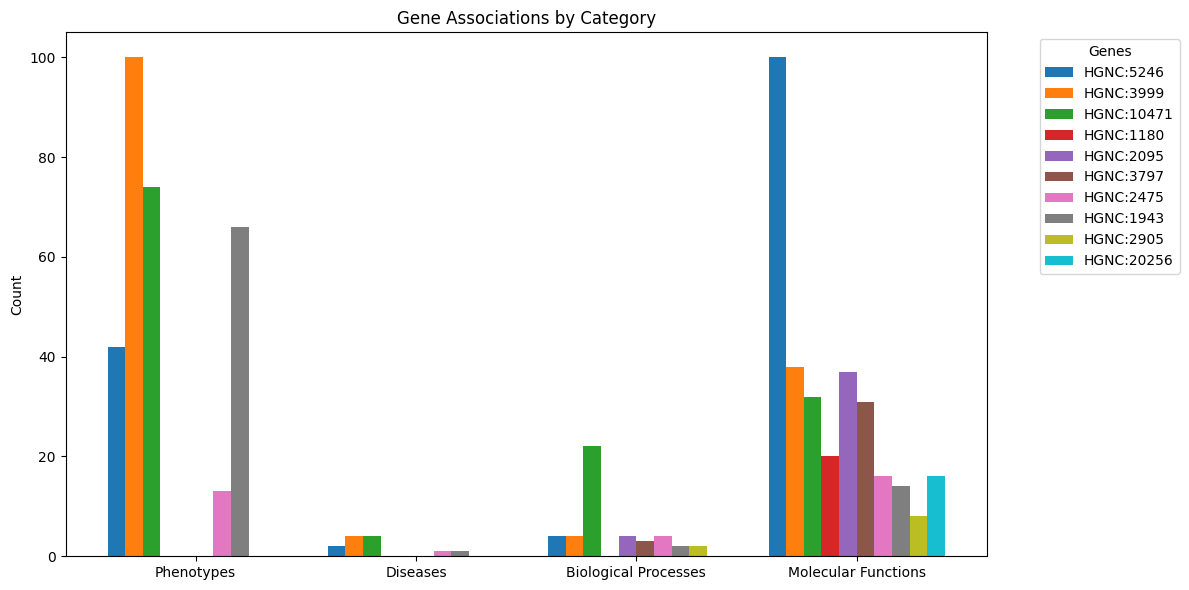

In [16]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

counts = defaultdict(lambda: defaultdict(int))
for gene, info in results.items():
    for category, items in info.items():
        counts[category][gene] = len(items)

categories = list(counts.keys())
genes = list(results.keys())
x = np.arange(len(categories))
width = 0.8 / len(genes)

fig, ax = plt.subplots(figsize=(12, 6))
for i, gene in enumerate(genes):
    gene_counts = [counts[category][gene] for category in categories]
    ax.bar(x + i*width, gene_counts, width, label=gene)

ax.set_ylabel('Count')
ax.set_title('Gene Associations by Category')
ax.set_xticks(x + width * (len(genes) - 1) / 2)
ax.set_xticklabels(categories)
ax.legend(title='Genes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()